# 3_model_building_LSTM_F13
-------------------
Group , November 18, 2022
1. Eduardo Garcia
2. Nari Kim
3. Thi Anh Ba Dang
4. Vishnu Prabhakar
5. VS Chaitanya Madduri
6. Yumeng Zhang


> <i>Description: Applying 7 Algorithms on the daily data.</i>

1. Dummy Predictor
2. Logistics Regresssion 
3. Random Forest
4. XGBoost
5. LGBM
6. FNN
7. Tabnet

 

- We are builing a basic model using the columns and the target provided in the intial dataset.

- Used Feature Set 13 which are basic features and we have calculated the Lag , Ta metrics


### Pre requisites: 
1. And add the shortcut of the drive link : https://drive.google.com/drive/folders/1F8P3UlqSE6lFpHyBidVArdsXJLenKi3O?usp=share_link to your personal drive.


Files:
crypto_data_hour_cleaned_v2.csv - Hourly Data

### Output files:

Files:model files



- Observation : Overall we have build 6 models and optimised 3 models to see if we can get best results. Amoung all the models we see best results with Xgboost and LGBM

# Load and transform data

In [2]:
## Packages to be installed
!pip install ta
!pip install bayesian-optimization
!pip install pytorch-tabnet
!pip install tensorflow-addons
!pip install verstack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29104 sha256=1f34b0eaf75b52aa36763f4041ae531a95013a545a86ce62c0fc790f6c157dba
  Stored in directory: /root/.cache/pip/wheels/31/31/f1/f2ff471bbc5b84a4b973698ceecdd453ae043971791adc3431
Successfully built ta
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 537 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 5.0 MB/s 
     |████████████████████████████████| 23.2 MB 1.4 MB/s 
     

In [6]:
## Import the packages
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost 
import pickle
import tensorflow

# import tensorflow_addons as tfa
import torch

from pytorch_tabnet.tab_model import TabNetClassifier
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import SGD, Adam
from sklearn.dummy import DummyClassifier
from ta import add_all_ta_features
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
#picking models for prediction.
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [7]:
from pip._internal.utils.misc import get_installed_distributions
import sys
#import numpy as np # imported to test whether numpy shows up, which it does!

def get_imported_packages():
    p = get_installed_distributions()
    p = {package.key:package.version for package in p}

    imported_modules = set(sys.modules.keys())
    
    imported_modules.remove('pip')

    modules = [(m, p[m]) for m in imported_modules if p.get(m, False)]

    return modules


def generate_requirements(filepath:str, modules):
    with open(filepath, 'w') as f:
        for module, version in modules:
            f.write(f"{module}=={version}")


generate_requirements('requirements.txt', get_imported_packages())

In [ ]:
# file path
folder_path = '/content/drive/MyDrive/MADS_23_DL_final_project'
daily = pd.read_csv('crypto_data_daily_cleaned_v1.csv')

In [ ]:
daily.head()

,Open Time,Open,High,Low,Close,Volume,train_test,Crypto
0,2013-04-01,93.155,105.90,93.155,104.750,11008.524,Train,BTC
1,2013-04-02,104.720,127.00,99.000,123.016,24187.398,Train,BTC
2,2013-04-03,123.001,146.88,101.511,125.500,31681.780,Train,BTC
3,2013-04-04,125.500,143.00,125.500,135.632,15035.206,Train,BTC
4,2013-04-05,136.000,145.00,135.119,142.990,11697.741,Train,BTC


# Train / Test Split

In [ ]:
# checking the Count of the records
daily['train_test'].value_counts(normalize=True)

Train    0.82546
Test     0.17454
Name: train_test, dtype: float64

In [ ]:
df = daily.copy()

In [ ]:
# train test split
train_df = df[df['train_test']=='Train']
test_df = df[df['train_test']=='Test']

In [ ]:
train_df.head()

,Open Time,Open,High,Low,Close,Volume,train_test,Crypto
0,2013-04-01,93.155,105.90,93.155,104.750,11008.524,Train,BTC
1,2013-04-02,104.720,127.00,99.000,123.016,24187.398,Train,BTC
2,2013-04-03,123.001,146.88,101.511,125.500,31681.780,Train,BTC
3,2013-04-04,125.500,143.00,125.500,135.632,15035.206,Train,BTC
4,2013-04-05,136.000,145.00,135.119,142.990,11697.741,Train,BTC


In [ ]:
train_df.columns

Index(['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'train_test',
       'Crypto'],
      dtype='object')

# Calculate percentage change

In [ ]:
def calculate_pct_change(df):
    '''
    The funnction calculate the pct Change for the all the records for one period.
    input:
    df: The input dataFrame
    output:
    df_pct_change : The dataframe with percentage Calculated.
    '''
    coins = df.Crypto.unique()
    df_pct_change = pd.DataFrame()
    for coin in coins:
        x = df[df['Crypto']==coin]
        x['pct_change_1day'] = x['Close'].pct_change(1)
        df_pct_change = pd.concat([df_pct_change,x])
    return df_pct_change

In [ ]:
train_df = calculate_pct_change(train_df)
test_df = calculate_pct_change(test_df)

In [ ]:
test_df.head()

,Open Time,Open,High,Low,Close,Volume,train_test,Crypto,pct_change_1day
3098,2021-10-01,43828.89,48500.00,43287.44,48165.76,38375.517,Test,BTC,NaN
3099,2021-10-02,48185.61,48361.83,47438.00,47657.69,12310.011,Test,BTC,-0.010548
3100,2021-10-03,47649.00,49300.00,47119.87,48233.99,14411.104,Test,BTC,0.012092
3101,2021-10-04,48233.99,49530.53,46895.80,49245.54,25695.213,Test,BTC,0.020972
3102,2021-10-05,49244.13,51922.00,49057.18,51493.99,30764.491,Test,BTC,0.045658


## Generate new features

### Lag features, moving average, exponential moving average and market cap

In [ ]:
def create_market_volumn_features(df):
  '''
  We are calculating the market volumn and weighttage.
  input:
  df: input data set
  output:
  merged: the output dataset with Total_value and Value_weights are added.
  '''
  # calculate value of each cryto at certain time points 
  df['Total_Value'] = df['Close']*df['Volume']
  # the sum of values at each time point
  sum_at_timepoints = df.groupby('Open Time').sum()['Total_Value']
  merged = df.merge(sum_at_timepoints, how='left',
                              on='Open Time', suffixes=('','_market'))
  merged['Value_Weight'] = merged['Total_Value']/merged['Total_Value_market']
    
  return merged

In [ ]:
def create_shift_features(df, col = 'pct_change_1day',lags=10, freq='daily'):
  '''
    Creating the lag volatitlity for the data. 
    input:
    df: the input dataframe 
    col: the column on which the calculation should be made.
    lags: The periods for which the calculations should be made
    freq: Teh frequencey or time period
    output: 
    df: the final dataframe withe lag columns added
  '''
  if freq=='daily':
    mul_fact = 1
    symbol = 'd'
  elif freq=='weekly':
    mul_fact = 7
    symbol = 'W'
  elif freq=='monthly':
    mul_fact = 31
    symbol = 'mon'
  else:
    # setting default to daily 
    mul_fact = 1
    symbol = 'd'

  for iterator in range(1,lags+1):
    
    df['{}_{}_lag'.format(iterator, symbol)] = df[col].shift(periods=iterator*mul_fact)
    # df.loc[:,"Volatility_{}_{}".format(iterator, symbol)] = df[col].rolling(iterator*mul_fact).std().shift(1)
    

  return df

In [ ]:
#list to collect all relevant lags 

def create_analysis_colums(df):
  '''
    Create the additional features for the model building 
    input:
    df: the input dataframe 
    output: 
    master_df: the final dataframe withe lag, ta columns added
  '''
  master_df = pd.DataFrame()
  crypto_coins = df['Crypto'].unique()

  for coin in crypto_coins:
    
    temp_df = df[df['Crypto']==coin]
    temp_df['pct_change_1day'] = temp_df['Close'].pct_change()
    
    # temp_df = create_shift_features(temp_df.copy(),col = 'pct_change_1day',lags=5, freq='weekly')
    temp_df = create_shift_features(temp_df.copy(),col = 'pct_change_1day',lags=2, freq='monthly')
    temp_df = create_shift_features(temp_df.copy(),col = 'pct_change_1day',lags=4, freq='weekly')
    temp_df = create_shift_features(temp_df.copy(),col = 'pct_change_1day',lags=8, freq='daily')
    temp_df = add_all_ta_features(temp_df.copy(), open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    if master_df.empty :
      master_df = temp_df
    else:
      master_df = pd.concat([master_df, temp_df])
  return master_df

In [ ]:
# Creating the additonal columns for the model building
train_df =create_analysis_colums(train_df)
test_df =create_analysis_colums(test_df)

In [ ]:
train_df.columns

Index(['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'train_test',
       'Crypto', 'pct_change_1day', '1_mon_lag',
       ...
       'momentum_ppo', 'momentum_ppo_signal', 'momentum_ppo_hist',
       'momentum_pvo', 'momentum_pvo_signal', 'momentum_pvo_hist',
       'momentum_kama', 'others_dr', 'others_dlr', 'others_cr'],
      dtype='object', length=109)

In [ ]:
# adding the total_value ratio and market value columns 
train_df =create_market_volumn_features(train_df.copy())
test_df =create_market_volumn_features(test_df.copy())

In [ ]:
# printing the 50 columns 
train_df.columns[:50]

Index(['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'train_test',
       'Crypto', 'pct_change_1day', '1_mon_lag', '2_mon_lag', '1_W_lag',
       '2_W_lag', '3_W_lag', '4_W_lag', '1_d_lag', '2_d_lag', '3_d_lag',
       '4_d_lag', '5_d_lag', '6_d_lag', '7_d_lag', '8_d_lag', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm'],
      dtype='object')

In [ ]:
# Based on our previous model building activities we have selected specific columns 
feat_to_keep = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'train_test',
       'Crypto', 'pct_change_1day','volatility_kcw','trend_cci','volume_adi','momentum_ppo_hist','momentum_stoch','volatility_kcp','volume_em',
             'volatility_dcw','volume_vpt','volatility_bbw','Total_Value', 'Total_Value_market', 'Value_Weight']
lag_cols = [col for col in train_df.columns if 'lag' in col]
#volatility_cols = [col for col in train_df.columns if 'Volatility' in col]
feat_to_keep.extend(lag_cols)
#feat_to_keep.extend(volatility_cols)

In [ ]:
# length of the columns selected
len(feat_to_keep)

36

In [ ]:
# slicing the tain and test columns
train_df = train_df[feat_to_keep]
test_df = test_df[feat_to_keep]

In [ ]:
# length of the columns selected
len(train_df.columns)

36

In [ ]:
# extracting the importatant features
impo_feat = ['volatility_kcw','trend_cci','volume_adi','momentum_ppo_hist','momentum_stoch','volatility_kcp','volume_em',
             'volatility_dcw','volume_vpt','volatility_bbw']
for feat in impo_feat:
  train_df[feat] = train_df[feat].shift(1)
  test_df[feat] = test_df[feat].shift(1)

## Extract year, month, day, hour and weekday from time stamp

### Encoding of ordinals

In [ ]:

def encode_cyclicals(df_x):
    '''
    The function converts the date features encoded in the Sine and cosines.
    Input : 
    df_x : Input data frame to be processed
    Output :
    df_x : processed dataframe.
    '''
    df_x['month_sin'] = np.sin(2*np.pi*df_x.month/12)
    df_x['month_cos'] = np.cos(2*np.pi*df_x.month/12)
    df_x.drop('month', axis=1, inplace=True)
    
    df_x['day_sin'] = np.sin(2*np.pi*df_x.day/31)
    df_x['day_cos'] = np.cos(2*np.pi*df_x.day/31)
    df_x.drop('day', axis=1, inplace=True)

    df_x['dayofweek_sin'] = np.sin(2*np.pi*df_x.weekday/7)
    df_x['dayofweek_cos'] = np.cos(2*np.pi*df_x.weekday/7)
    df_x.drop('weekday', axis=1, inplace=True)
    
    df_x['hour_sin'] = np.sin(2*np.pi*df_x.hour/24)
    df_x['hour_cos'] = np.cos(2*np.pi*df_x.hour/24)
    df_x.drop('hour', axis=1, inplace=True)

    df_x['hour_sin'] = np.sin(2*np.pi*df_x.minute/60)
    df_x['hour_cos'] = np.cos(2*np.pi*df_x.minute/60)
    df_x.drop('minute', axis=1, inplace=True)
    
   
    
    return df_x

In [ ]:
def date_values_extraction(new_df):
    '''
  The function to split the date columns.
  Input : 
  new_df : Input data frame to be processed
  Output :
  df : processed dataframe.
  '''
  df = new_df.copy()
  df['year'] = pd.DatetimeIndex(df['Open Time']).year
  df['month'] = pd.DatetimeIndex(df['Open Time']).month
  df['day'] = pd.DatetimeIndex(df['Open Time']).day
  df['weekday'] = pd.DatetimeIndex(df['Open Time']).dayofweek


  df['Open Time'] = pd.to_datetime(df['Open Time'])
  df['minute'] = df['Open Time'].dt.minute
  df['hour'] = df['Open Time'].dt.hour
  df = encode_cyclicals(df.copy())
  return df

In [ ]:
# Extract the date featues
train_df = date_values_extraction(train_df)
test_df = date_values_extraction(test_df)

## One hot coding the coins


In [ ]:
# Applying one hot encoding on Crypto Coin 
def crypto_one_hot_encoding(df):
  '''
  The funtion which converts the crypto into individual columns.
  Input : 
  df : Input data frame to be processed
  Output :
  df : processed dataframe.
  '''
  y_dummies = pd.get_dummies(df['Crypto'], prefix='Crypto', drop_first= False)
  df = pd.concat([df, y_dummies], axis=1)
  df.drop(['Crypto'], axis=1, inplace=True)
  # creating a additional column if the model is used for new coin.
  df['other_crypto'] =0
  return df

In [ ]:
# The train and test where one hot encoded
train_df = crypto_one_hot_encoding(train_df)
test_df = crypto_one_hot_encoding(test_df)

In [ ]:
train_df['pct_change_1day'].describe()

count    17115.000000
mean         0.005533
std          0.162083
min         -0.564847
25%         -0.025641
50%          0.000000
75%          0.028824
max         19.058824
Name: pct_change_1day, dtype: float64

In [ ]:
test_df['pct_change_1day'].describe()

count    3611.000000
mean       -0.001452
std         0.046840
min        -0.204696
25%        -0.026274
50%         0.000000
75%         0.024091
max         0.344702
Name: pct_change_1day, dtype: float64

# Defining the Target Variable. 


We devide the data into 3 classes, one is with return below 0, one is above 0 but below market rate of return, one is above market rate of return. The market rate of return we use here is annual return of S&P 500 index in 2021.

In [ ]:
def create_target(df):
  '''
  The funtion which extracts the target columns from pct_change_1day
  Input : 
  df : Input data frame to be processed
  Output :
  df : processed dataframe.
  '''
  market_RoR = 26.89
  market_RoR_1d = market_RoR/365
  df['Target'] = np.where(df['pct_change_1day']>0, 1,0)
  df['Target'] = np.where(df['pct_change_1day']>market_RoR_1d, 2,1)
  df['Target'][df['Target']==1] = np.where(df['pct_change_1day'][df['Target']==1]>=0, 1,0)
  return df

In [ ]:
# Applying the target columns 
train_df = create_target(train_df)
test_df = create_target(test_df)

In [ ]:
train_df['Target'].value_counts(normalize=True)

0    0.460088
1    0.449343
2    0.090569
Name: Target, dtype: float64

In [ ]:
test_df['Target'].value_counts(normalize=True)

0    0.491025
1    0.464513
2    0.044463
Name: Target, dtype: float64

In [ ]:
test_df.drop(['pct_change_1day'], axis=1, inplace=True) # droppping the column as we already extracted the target
train_df.drop(['pct_change_1day'], axis=1, inplace=True) # droppping the column as we already extracted the target

In [ ]:
train_df.shape

(17125, 55)

In [ ]:
test_df.shape

(3621, 55)

In [ ]:
target = train_df['Target']
test_target = test_df['Target']

### Drop  columns

In [ ]:

train_df.drop(['Target','Open Time','train_test',],axis=1,inplace=True)

In [ ]:

test_df.drop(['Target','Open Time','train_test',],axis=1,inplace=True)

<AxesSubplot:>

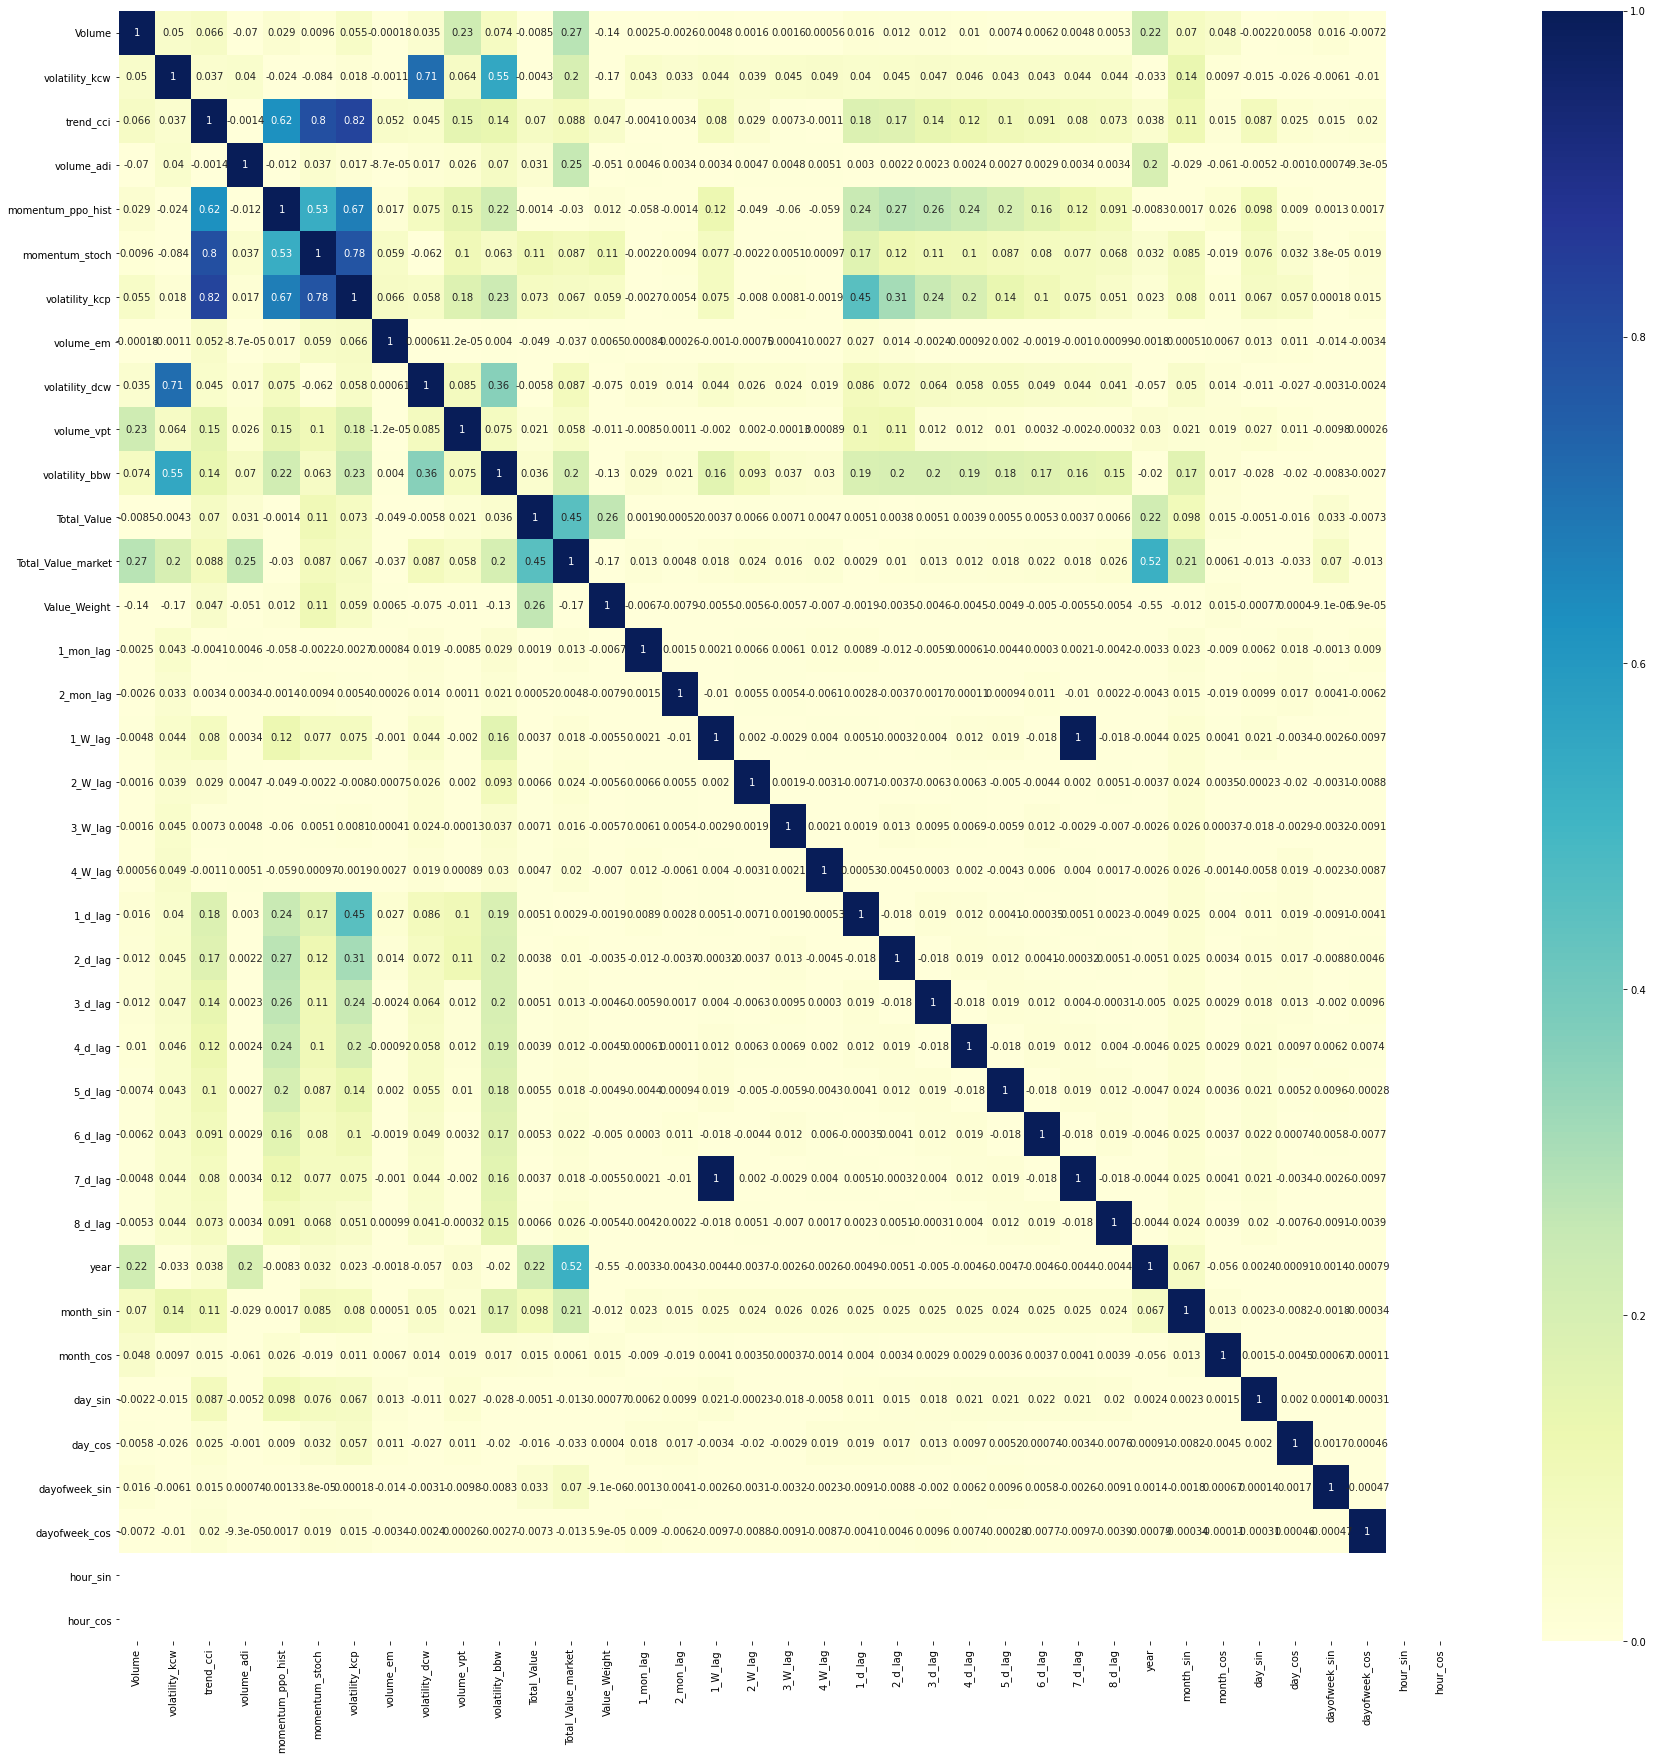

In [ ]:
plt.figure(figsize=(30,30))

corr = train_df.drop(['Open','High', 'Low','Close','Crypto_ADA',
      'Crypto_BTC', 'Crypto_ETC', 'Crypto_ETH', 'Crypto_LINK', 'Crypto_LTC',
      'Crypto_TRX', 'Crypto_XLM', 'Crypto_XMR', 'Crypto_XRP', 'other_crypto'],axis=1).corr()
       
sns.heatmap(corr,vmin=0, vmax=1, annot=True, cmap="YlGnBu")

- The correlation matrix shows that columns are not much correlated each other.

In [ ]:
# dropping the listof the columns 
# drop_columns = []
drop_columns = ['Open','Close']


if drop_columns:
  norm_train_df = train_df.drop(drop_columns,axis=1)
  norm_test_df = test_df.drop(drop_columns,axis=1)
else:
  norm_train_df = train_df
  norm_test_df = test_df

In [ ]:
norm_train_df.columns

Index(['High', 'Low', 'Volume', 'volatility_kcw', 'trend_cci', 'volume_adi',
       'momentum_ppo_hist', 'momentum_stoch', 'volatility_kcp', 'volume_em',
       'volatility_dcw', 'volume_vpt', 'volatility_bbw', 'Total_Value',
       'Total_Value_market', 'Value_Weight', '1_mon_lag', '2_mon_lag',
       '1_W_lag', '2_W_lag', '3_W_lag', '4_W_lag', '1_d_lag', '2_d_lag',
       '3_d_lag', '4_d_lag', '5_d_lag', '6_d_lag', '7_d_lag', '8_d_lag',
       'year', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'dayofweek_sin',
       'dayofweek_cos', 'hour_sin', 'hour_cos', 'Crypto_ADA', 'Crypto_BTC',
       'Crypto_ETC', 'Crypto_ETH', 'Crypto_LINK', 'Crypto_LTC', 'Crypto_TRX',
       'Crypto_XLM', 'Crypto_XMR', 'Crypto_XRP', 'other_crypto'],
      dtype='object')

In [ ]:
norm_train_df.shape

(17125, 50)

In [ ]:
target.shape

(17125,)

In [ ]:

def generate_model_report(y_actual, y_predicted, metric_type):
    '''
    This function we are calculating the main metrics
    input:
    y_actual: the actual values
    y_predicted : The predicted values 
    metric_type : which type of metric 
    '''
    print("==================Printing the {} metrics===================".format(metric_type))
    if metric_type=='micro':
      print("Accuracy = " , round(accuracy_score(y_actual, y_predicted),3))
    print("Precision = " ,round(precision_score(y_actual, y_predicted, average=metric_type),3))
    print("Recall = " ,round(recall_score(y_actual, y_predicted, average=metric_type),3))
    print("F1 Score = " ,round(f1_score(y_actual, y_predicted, average=metric_type),3))
    print("=====================================")

# Model Building

## Dummy classifier
The baseline Model which others model should be beating.

In [ ]:
# Fitting the Dummt classifier 

dummy_model = DummyClassifier(strategy='prior')

dummy_model.fit(train_df.fillna(0), target)

DummyClassifier()

In [ ]:
# predicting the values
dummy_pred = dummy_model.predict(test_df)

In [ ]:
# Evaluation metrics
generate_model_report(test_target, dummy_pred, 'micro')
generate_model_report(test_target, dummy_pred, 'macro')
generate_model_report(test_target, dummy_pred, 'weighted')


print('\nClassification Report\n')
print(classification_report(test_target, dummy_pred))

==================Printing the micro metrics===================
Accuracy =  0.491
Precision =  0.491
Recall =  0.491
F1 Score =  0.491
==================Printing the macro metrics===================
Precision =  0.164
Recall =  0.333
F1 Score =  0.22
==================Printing the weighted metrics===================
Precision =  0.241
Recall =  0.491
F1 Score =  0.323

Classification Report

              precision    recall  f1-score   support

           0       0.49      1.00      0.66      1778
           1       0.00      0.00      0.00      1682
           2       0.00      0.00      0.00       161

    accuracy                           0.49      3621
   macro avg       0.16      0.33      0.22      3621
weighted avg       0.24      0.49      0.32      3621



In [ ]:
# Saving the file 
import pickle
# temp_file_path = '/content/drive/MyDrive/MADS_23_DL_final_project/data/model_files/LGBM_hourly'
with open( 'dummy_f13_final.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(dummy_model, f) 

## Logistic Regression


In [ ]:
# Building the Logistic Regression Model

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')                            # Set Large C value for low regularization to prevent overfitting
logreg.fit(train_df.fillna(0), target)



LogisticRegression(multi_class='multinomial')

In [ ]:
# Predicting teh 
logreg_pred = logreg.predict(test_df.fillna(0))

In [ ]:
generate_model_report(test_target, logreg_pred, 'micro')
generate_model_report(test_target, logreg_pred, 'macro')
generate_model_report(test_target, logreg_pred, 'weighted')

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(test_target, logreg_pred))

==================Printing the micro metrics===================
Accuracy =  0.493
Precision =  0.493
Recall =  0.493
F1 Score =  0.493
==================Printing the macro metrics===================
Precision =  0.353
Recall =  0.335
F1 Score =  0.233
==================Printing the weighted metrics===================
Precision =  0.505
Recall =  0.493
F1 Score =  0.341

Classification Report

              precision    recall  f1-score   support

           0       0.49      0.98      0.66      1778
           1       0.56      0.02      0.04      1682
           2       0.00      0.00      0.00       161

    accuracy                           0.49      3621
   macro avg       0.35      0.33      0.23      3621
weighted avg       0.50      0.49      0.34      3621



## XGBoost - Untuned

In [ ]:
%timeit
# Fitting the untuned xgclassifier
xgb_clf = XGBClassifier(num_class = 2, 
                        objective="multi:softprob", 
                        n_estimators = 1000,
                        max_depth = 30, 
                        eval_metric ='mlogloss', n_jobs=-1)
xgb_clf.fit(norm_train_df, target)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=30, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              num_class=2, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, ...)

In [ ]:
xgb_clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=30, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              num_class=2, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, ...)

In [ ]:
# Predicting the values 
predicted_values = xgb_clf.predict(norm_test_df)

In [ ]:
# Evaluation metrics
generate_model_report(test_target, predicted_values, 'micro')
generate_model_report(test_target, predicted_values, 'macro')
generate_model_report(test_target, predicted_values, 'weighted')

==================Printing the micro metrics===================
Accuracy =  0.5
Precision =  0.5
Recall =  0.5
F1 Score =  0.5
==================Printing the macro metrics===================
Precision =  0.396
Recall =  0.399
F1 Score =  0.393
==================Printing the weighted metrics===================
Precision =  0.506
Recall =  0.5
F1 Score =  0.497


In [ ]:

print('\nClassification Report\n')
print(classification_report(test_target, predicted_values))


Classification Report

              precision    recall  f1-score   support

           0       0.54      0.42      0.48      1778
           1       0.50      0.61      0.55      1682
           2       0.14      0.16      0.15       161

    accuracy                           0.50      3621
   macro avg       0.40      0.40      0.39      3621
weighted avg       0.51      0.50      0.50      3621



In [ ]:
# Saving the file 

temp_file_path = '/content/drive/MyDrive/MADS_23_DL_final_project/data/model_files/LGBM_hourly'
with open( 'XGBoost_f13_final.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(xgb_clf, f) 

## XGBoost tuning with Bayesian optimization

In [ ]:

def xgbc_cv( max_depth,
                n_estimators,
                gamma,
                learning_rate,
                min_child_weight,
                
                 subsample):
    
    
    
    estimator_function = XGBClassifier(max_depth=int(max_depth),
                                           learning_rate= learning_rate,
                                           n_estimators= int(n_estimators),
                                           min_child_weight = int(min_child_weight),
                                           nthread = -1,
                                           subsample =  max(subsample, 0),
                                           objective="multi:softprob",  
                                           eval_metric = 'mlogloss',
                                           num_class = 2,
                                           scoring='f1',
                                           seed = 32)
    # Fit the estimator
    
    estimator_function.fit(norm_train_df.fillna(0), target)
    
    # calculate out-of-the-box roc_score using validation set 1
    predicted_values = estimator_function.predict(norm_test_df.fillna(0))
    score = f1_score(test_target, predicted_values, average='weighted')

    
    # return the mean validation score to be maximized 
    return score


def bayesOpt(train_x, train_y):
    lgbBO = BayesianOptimization(xgbc_cv, {
                                              "max_depth": (25,30),
                                              "n_estimators": (600,1000) , 
                                              "gamma": (0.03,0.05), 
                                              "learning_rate": (0.04,0.09 ),
                                              "min_child_weight": (5,20), 
                                              # "colsample_bytree":(0.4,0.8), 
                                              "subsample": (0.50,0.85)
                                              }
                                 )


    lgbBO.maximize(init_points=5, n_iter=30)

#     print(lgbBO.res['max'])
    print(lgbBO.max)
    

bayesOpt(norm_train_df.fillna(0), target)

|   iter    |  target   |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
[16:22:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


| 1         | 0.4862    | 0.03422   | 0.08214   | 25.59     | 11.82     | 616.8     | 0.7609    |
[16:24:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core,

| 15        | 0.482     | 0.04285   | 0.07545   | 27.15     | 13.31     | 821.8     | 0.6563    |
[17:02:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


| 16        | 0.4894    | 0.04647   | 0.07957   | 27.57     | 5.832     | 868.4     | 0.7801    |
[17:05:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if

| 30        | 0.4929    | 0.04517   | 0.05115   | 27.94     | 13.46     | 709.4     | 0.806     |
[17:37:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


| 31        | 0.4831    | 0.04625   | 0.0843    | 26.4      | 12.3      | 733.7     | 0.5804    |
[17:38:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if

## RandomizedSearchCV - XGBoost


In [ ]:
# Importing RandomizedSearchCV

In [ ]:


# EG Fitting 3 folds for each of 100 candidates, totalling 300 fits
xg_random = RandomizedSearchCV(estimator = xgb_clf, 
                               param_distributions = param_grid, 
                               n_iter = 10, 
                               cv = 3, 
                               verbose=1 , 
                               scoring='f1',
                               n_jobs=-1,
                               random_state=42)

In [ ]:
xg_random.fit(norm_train_df, target)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(eval_metric='mlogloss', max_depth=30,
                                           n_jobs=-1, num_class=2,
                                           objective='multi:softprob'),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.4, 0.8],
                                        'gamma': [0.03, 0.05],
                                        'learning_rate': [0.02, 0.09],
                                        'min_child_weight': [5, 10],
                                        'n_estimators': [300, 400, 500],
                                        'subsample': [0.5, 0.85]},
                   random_state=42, scoring='f1', verbose=1)

In [ ]:
xg_random.cv_results_

{'mean_fit_time': array([284.74294734, 533.94794067, 324.38395802, 273.51564415,
        217.38379757, 293.17546924, 320.41527597, 107.98551663,
        143.0566748 , 188.16923523]),
 'std_fit_time': array([16.54543366, 39.83647681, 22.32838181, 19.46776648, 15.59290301,
        21.21693124, 28.53303815,  7.15326628,  9.65456451, 14.22315131]),
 'mean_score_time': array([ 4.39842884, 17.06368883,  5.13770858,  2.45175536,  8.86828566,
         3.52253485,  2.5757939 ,  1.60393675,  3.2699577 ,  7.45017727]),
 'std_score_time': array([0.29605027, 1.46149761, 0.1760782 , 0.10329311, 1.60875665,
        0.98636956, 0.13675698, 0.13713717, 0.52527974, 0.8564662 ]),
 'param_subsample': masked_array(data=[0.5, 0.85, 0.85, 0.5, 0.85, 0.85, 0.85, 0.5, 0.5, 0.5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[400, 500, 300, 500, 400, 300, 

In [ ]:
xg_random

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(eval_metric='mlogloss', max_depth=30,
                                           n_jobs=-1, num_class=2,
                                           objective='multi:softprob'),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.4, 0.8],
                                        'gamma': [0.03, 0.05],
                                        'learning_rate': [0.02, 0.09],
                                        'min_child_weight': [5, 10],
                                        'n_estimators': [300, 400, 500],
                                        'subsample': [0.5, 0.85]},
                   random_state=42, scoring='f1', verbose=1)

In [ ]:
# Picking teh best estimator
final_model = xg_random.best_estimator_

In [ ]:
# Saving the file 

temp_file_path = '/content/drive/MyDrive/MADS_23_DL_final_project/data/model_files/svc_hourly'
with open(temp_file_path + '/xgb_clf_f13.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(final_model, f) 

In [ ]:
# Predicting the values
predicted_values = final_model.predict(norm_test_df)

In [ ]:
# calculating the metrics
generate_model_report(test_target, predicted_values, 'micro')
generate_model_report(test_target, predicted_values, 'macro')
generate_model_report(test_target, predicted_values, 'weighted')

==================Printing the micro metrics===================
Accuracy =  0.511
Precision =  0.511
Recall =  0.511
F1 Score =  0.511
==================Printing the macro metrics===================
Precision =  0.394
Recall =  0.373
F1 Score =  0.373
==================Printing the weighted metrics===================
Precision =  0.503
Recall =  0.511
F1 Score =  0.501


In [ ]:
# Best params
param_grid =  {'gamma': 0.03127013296857564, 'learning_rate': 0.04498314951689869, 'max_depth': 29.401153112346318, 'min_child_weight': 11.719617320022135, 'n_estimators': 686.8341805804602, 'subsample': 0.7094565386859188}

In [ ]:
param_grid

{'gamma': 0.03127013296857564,
 'learning_rate': 0.04498314951689869,
 'max_depth': 29.401153112346318,
 'min_child_weight': 11.719617320022135,
 'n_estimators': 686.8341805804602,
 'subsample': 0.7094565386859188}

In [ ]:
%timeit

xgb_clf = XGBClassifier(num_class = 2, 
                        
                        learning_rate =param_grid['learning_rate'],
                        n_estimators = int(param_grid['n_estimators']),
                        gamma= param_grid['gamma'],
                        max_depth = int(param_grid['max_depth']), 
                        subsample= param_grid['subsample'],
                        objective="multi:softprob",  
                        eval_metric = 'mlogloss',
                        n_jobs=-1,num_boost_round=15)


xgb_clf.fit(norm_train_df.fillna(0), target)


[20:06:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0.03127013296857564, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.04498314951689869, max_delta_step=0, max_depth=29,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=686, n_jobs=-1, num_boost_round=15, num_class=2,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.7094565386859188, tree_method='exact', ...)

In [ ]:
xgb_clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0.03127013296857564, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.04498314951689869, max_delta_step=0, max_depth=29,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=686, n_jobs=-1, num_boost_round=15, num_class=2,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.7094565386859188, tree_method='exact', ...)

In [ ]:
predicted_values = xgb_clf.predict(norm_test_df)

In [ ]:
generate_model_report(test_target, predicted_values, 'micro')
generate_model_report(test_target, predicted_values, 'macro')
generate_model_report(test_target, predicted_values, 'weighted')

==================Printing the micro metrics===================
Accuracy =  0.502
Precision =  0.502
Recall =  0.502
F1 Score =  0.502
==================Printing the macro metrics===================
Precision =  0.381
Recall =  0.379
F1 Score =  0.374
==================Printing the weighted metrics===================
Precision =  0.507
Recall =  0.502
F1 Score =  0.496


In [ ]:
# Saving the file 
import pickle
# temp_file_path = '/content/drive/MyDrive/MADS_23_DL_final_project/data/model_files/svc_hourly'
with open('xgb_clf_f13_tuned.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(final_model, f) 

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/MADS_23_DL_final_project/data/model_files/svc_hourly/xgb_clf_f13_tuned.pkl'

In [ ]:

print('\nClassification Report\n')
print(classification_report(test_target, predicted_values))


Classification Report

              precision    recall  f1-score   support

           0       0.54      0.42      0.48      1778
           1       0.50      0.61      0.55      1682
           2       0.14      0.16      0.15       161

    accuracy                           0.50      3621
   macro avg       0.40      0.40      0.39      3621
weighted avg       0.51      0.50      0.50      3621



In [ ]:
xgb_clf

## Fully Connected Neural Network 

In [ ]:


# USE KERAS FUNKTIONAl API!


# Parameters
############

hidden_size_1 = 1024
hidden_size_2 = 2048
hidden_size_3 = 1024
number_of_classes =3

# Model
#######

inputs = Input(shape=(norm_train_df.fillna(0).shape[1]))

# Hidden layer
##############

hidden_output = Dense(hidden_size_1, activation='relu')(inputs)
hidden_output = Dropout(0.5)(hidden_output)
hidden_output_2 = Dense(hidden_size_2, activation='relu')(hidden_output)
hidden_output_2 = Dropout(0.3)(hidden_output_2)
hidden_output_3 = Dense(hidden_size_3, activation='relu')(hidden_output_2)

# Softmax 
#########


predictions = Dense(3, activation='softmax')(hidden_output_3)

# Whole model
##############
# Nothing more is left, than to instantiate the model
# Please ensure input and output is right!

model = Model(inputs=inputs, outputs=predictions)

# Optimization
##############
# For now, we stick to this.
optimizer = Adam(lr=0.01)
 

# Compilation and teaching
##########################

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', # use this cross entropy variant
                                                      # since the input is not one-hot encoded
              metrics=[ 'accuracy']) #We measure and print accuracy during training

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 54)]              0         
                                                                 
 dense_8 (Dense)             (None, 1024)              56320     
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 2048)              2099200   
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_11 (Dense)            (None, 3)                 3075

In [ ]:
# fitting the model
model.fit(x=norm_train_df.fillna(0), 
          y=target,
          validation_data=(norm_test_df.fillna(0), test_target),
          epochs=30,
          batch_size=32)



Epoch 1/30
536/536 [==============================] - 19s 34ms/step - loss: 85875304.0000 - accuracy: 0.4516 - val_loss: 0.8601 - val_accuracy: 0.4910
Epoch 2/30
536/536 [==============================] - 18s 34ms/step - loss: 5603.3916 - accuracy: 0.4548 - val_loss: 0.8589 - val_accuracy: 0.4910
Epoch 3/30
536/536 [==============================] - 19s 36ms/step - loss: 20654.1816 - accuracy: 0.4558 - val_loss: 0.8585 - val_accuracy: 0.4910
Epoch 4/30
536/536 [==============================] - 18s 34ms/step - loss: 914.0923 - accuracy: 0.4566 - val_loss: 0.8556 - val_accuracy: 0.4645
Epoch 5/30
536/536 [==============================] - 19s 35ms/step - loss: 3122.2930 - accuracy: 0.4604 - val_loss: 0.8577 - val_accuracy: 0.4910
Epoch 6/30
536/536 [==============================] - 19s 35ms/step - loss: 459.7038 - accuracy: 0.4575 - val_loss: 0.8591 - val_accuracy: 0.4645
Epoch 7/30
536/536 [==============================] - 19s 35ms/step - loss: 219.5765 - accuracy: 0.4569 - val_loss:

In [ ]:
# Predicting the test data 
nn_pred=model.predict(norm_test_df.fillna(0))

114/114 [==============================] - 8s 68ms/step


In [ ]:
# Extracting the argmax
df = pd.DataFrame(nn_pred)
nn_pred = df.idxmax(axis=1)

In [ ]:
# Evaluation metrics
generate_model_report(test_target, nn_pred, 'micro')
generate_model_report(test_target, nn_pred, 'macro')
generate_model_report(test_target, nn_pred, 'weighted')

==================Printing the micro metrics===================
Accuracy =  0.4645
Precision =  0.4645
Recall =  0.4645
F1 Score =  0.4645
==================Printing the macro metrics===================
Precision =  0.1548
Recall =  0.3333
F1 Score =  0.2115
==================Printing the weighted metrics===================
Precision =  0.2158
Recall =  0.4645
F1 Score =  0.2947


In [ ]:

print('\nClassification Report\n')
print(classification_report(test_target, nn_pred))

## Tabnet 

In [ ]:
# define the model and fit 
clf1_nopreproc = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

# fit the model 
clf1_nopreproc.fit(
    norm_train_df.fillna(0).values, target.values,
    eval_set=[(norm_train_df.fillna(0).values, target.values), (norm_test_df.fillna(0).values, test_target.values)],
    eval_name=['train', 'valid'],
    eval_metric=['balanced_accuracy'],
    max_epochs=150 , patience=120,
    batch_size=64, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
)  

epoch 0  | loss: 1.08729 | train_balanced_accuracy: 0.42932 | valid_balanced_accuracy: 0.39624 |  0:00:06s
epoch 1  | loss: 1.03804 | train_balanced_accuracy: 0.45699 | valid_balanced_accuracy: 0.41154 |  0:00:15s
epoch 2  | loss: 1.03205 | train_balanced_accuracy: 0.44434 | valid_balanced_accuracy: 0.37765 |  0:00:23s
epoch 3  | loss: 1.0262  | train_balanced_accuracy: 0.46195 | valid_balanced_accuracy: 0.38644 |  0:00:29s
epoch 4  | loss: 1.0118  | train_balanced_accuracy: 0.44718 | valid_balanced_accuracy: 0.35146 |  0:00:36s
epoch 5  | loss: 1.00969 | train_balanced_accuracy: 0.46104 | valid_balanced_accuracy: 0.38105 |  0:00:43s
epoch 6  | loss: 1.00283 | train_balanced_accuracy: 0.47166 | valid_balanced_accuracy: 0.4123  |  0:00:50s
epoch 7  | loss: 1.00314 | train_balanced_accuracy: 0.48128 | valid_balanced_accuracy: 0.40423 |  0:00:56s
epoch 8  | loss: 0.99158 | train_balanced_accuracy: 0.47601 | valid_balanced_accuracy: 0.39889 |  0:01:02s
epoch 9  | loss: 0.99393 | train_bala

In [ ]:
# plot losses
# plt.plot(clf1_nopreproc.history['valid_logloss'])

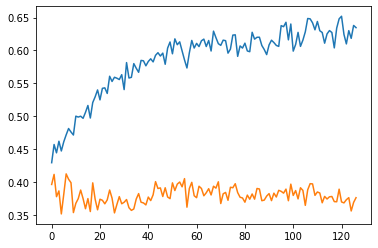

In [ ]:
# plot accuracy
plt.plot(clf1_nopreproc.history['train_balanced_accuracy'])
plt.plot(clf1_nopreproc.history['valid_balanced_accuracy'])

In [ ]:
# Saving the file 
import pickle
temp_file_path = '/content/drive/MyDrive/MADS_23_DL_final_project/data/model_files/Tabnet'
# clf1_nopreproc.save(temp_file_path + '/Tabnet_model.h5')  # creates a HDF5 file 'my_model.h5'

with open(temp_file_path + '/tabnet_v2.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(clf1_nopreproc, f) 

In [ ]:

nn_pred= clf1_nopreproc.predict(norm_test_df.fillna(0).values)

In [ ]:
nn_pred.value_counts()

AttributeError: ignored

In [ ]:

df = pd.DataFrame(nn_pred)
nn_pred = df.idxmax(axis=1)

In [ ]:

generate_model_report(test_target, nn_pred, 'micro')
generate_model_report(test_target, nn_pred, 'macro')
generate_model_report(test_target, nn_pred, 'weighted')

In [ ]:

print('\nClassification Report\n')
print(classification_report(test_target, nn_pred))

In [ ]:
# Creating  a confusion matrix,which compares the y_test and y_pred

cm = confusion_matrix(test_target, nn_pred)


# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['below_0','above_0','above_market'], 
                     columns = ['below_0','above_0','above_market'])


#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

plt.show()


End of the Notebook

## Random forest classifier

In [ ]:
# fitting the model
model = RandomForestClassifier(n_estimators=500, random_state=1,max_depth=8,n_jobs=-1)
model.fit(norm_train_df.fillna(0), target)

RandomForestClassifier(max_depth=8, n_estimators=500, n_jobs=-1, random_state=1)

In [ ]:
target_test_pred = model.predict(norm_test_df.fillna(0))

In [ ]:
generate_model_report(test_target, target_test_pred, 'micro')
generate_model_report(test_target, target_test_pred, 'macro')
generate_model_report(test_target, target_test_pred, 'weighted')

==================Printing the micro metrics===================
Accuracy =  0.506
Precision =  0.506
Recall =  0.506
F1 Score =  0.506
==================Printing the macro metrics===================
Precision =  0.338
Recall =  0.354
F1 Score =  0.345
==================Printing the weighted metrics===================
Precision =  0.485
Recall =  0.506
F1 Score =  0.494


Text(0.5, 0, 'Relative Importance')

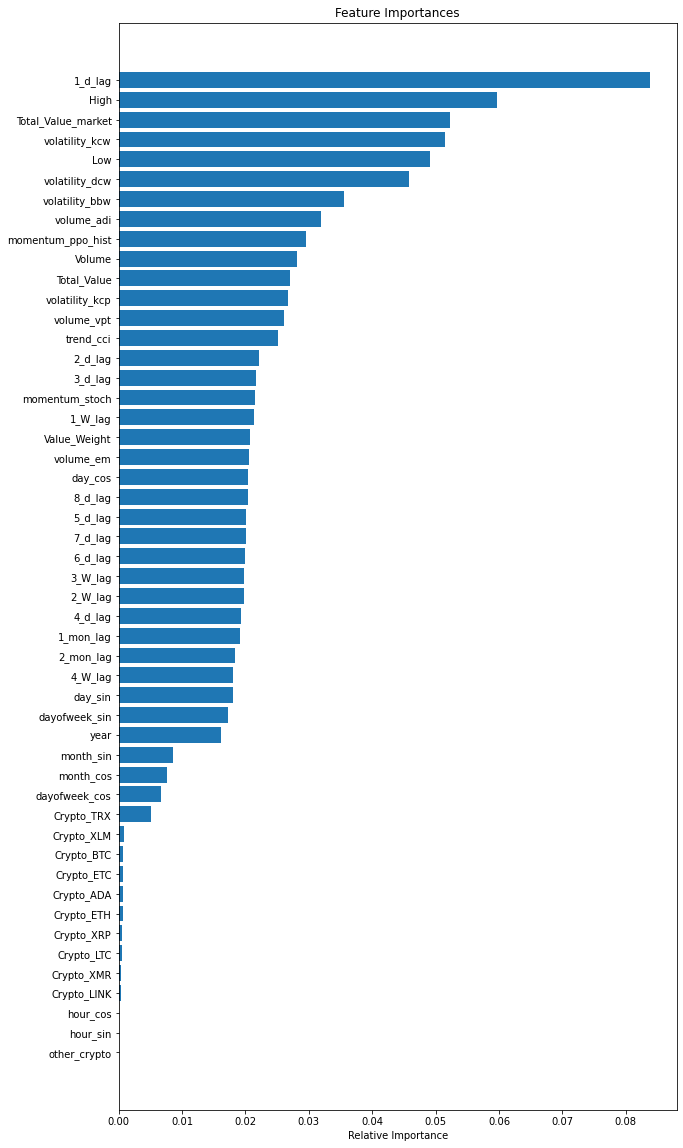

In [ ]:
# Feature importance 
features=norm_train_df.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

## LGBM tuning with optuna


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 20 trials
     .. Evaluation metric: f1_macro 
     .. Study direction: minimize log_loss

     . Trial number: 0 finished
     .. Optimization score (lower-better): log_loss: 0.7677924794265247
     .. Evaluation score (greater-better): f1_macro: 0.5203214698753702
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): log_loss: 0.7593523232768736
     .. Evaluation score (greater-better): f1_macro: 0.5097983602870538
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): log_loss: 0.774663563326048
     .. Evaluation score (greater-better): f1_macro: 0.5199973165458244
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): log_loss: 0.774

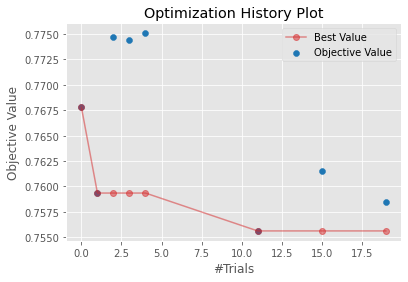

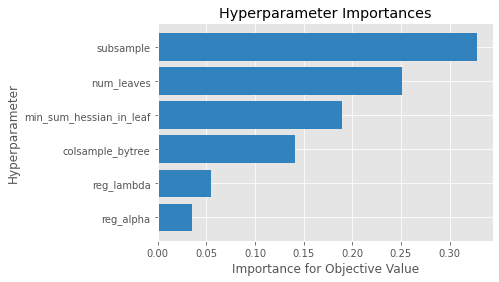

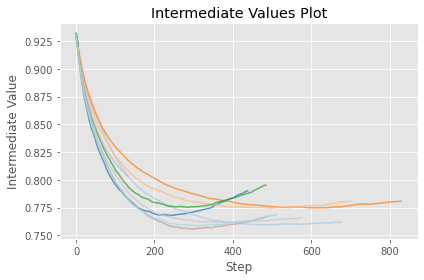

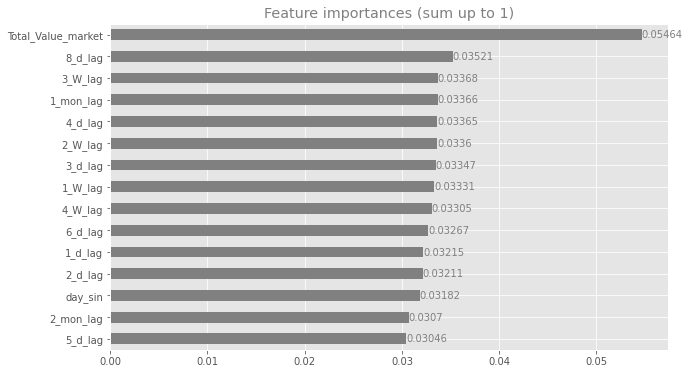


     . Optuna hyperparameters optimization finished
     .. Best trial number:11    |     log_loss:           0.7556247573923124
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  319   |     multi_logloss:           0.7573285095803589

Time elapsed for fit execution: 6 min 3.876 sec


In [ ]:
from verstack import LGBMTuner
tuned_lgbm = LGBMTuner(metric = 'f1_macro', trials = 20) 
tuned_lgbm.fit(norm_train_df.fillna(0), target)

In [ ]:
tuned_lgbm.best_params

{'task': 'train',
 'learning_rate': 0.02,
 'num_leaves': 177,
 'colsample_bytree': 0.6277217293825994,
 'subsample': 0.9154787443696969,
 'bagging_freq': 1,
 'max_depth': -1,
 'verbosity': -1,
 'reg_alpha': 1.2005946274475368e-08,
 'reg_lambda': 1.210727364048483e-08,
 'min_split_gain': 0.0,
 'zero_as_missing': False,
 'max_bin': 255,
 'min_data_in_bin': 3,
 'random_state': 42,
 'num_classes': 3,
 'objective': 'multiclass',
 'metric': 'multi_logloss',
 'num_threads': 0,
 'min_sum_hessian_in_leaf': 0.1610128003061735,
 'n_estimators': 319}

In [ ]:
tuned_lgbm

LGBMTuner(Evaluation metric: f1_macro            
          trials: 20            
          refit: True            
          verbosity: 1            
          visualization: True)

In [ ]:
tuned_lgbm_pred = tuned_lgbm.predict(norm_test_df)

In [ ]:
generate_model_report(test_target, tuned_lgbm_pred, 'micro')
generate_model_report(test_target, tuned_lgbm_pred, 'macro')
generate_model_report(test_target, tuned_lgbm_pred, 'weighted')

==================Printing the micro metrics===================
Accuracy =  0.518
Precision =  0.518
Recall =  0.518
F1 Score =  0.518
==================Printing the macro metrics===================
Precision =  0.433
Recall =  0.379
F1 Score =  0.376
==================Printing the weighted metrics===================
Precision =  0.517
Recall =  0.518
F1 Score =  0.501


In [ ]:
# Saving the file 
import pickle
temp_file_path = '/content/drive/MyDrive/MADS_23_DL_final_project/data/model_files/LGBM_hourly'
with open(temp_file_path + '/tuned_lgbm_f13_final.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(tuned_lgbm, f) 

## LGBM After Optimisation

In [ ]:
import lightgbm as lgb

untuned_lgbm = lgb.LGBMClassifier( learning_rate= 0.02,
 num_leaves= 185,
 colsample_bytree= 0.9973006775338719,
 subsample= 0.8626362747879762,
 bagging_freq= 1,
 max_depth= -1,
 verbosity= -1,
 reg_alpha= 0.6849391813640976,
 reg_lambda= 1.4776089934723414e-08,
 min_split_gain= 0.0,
 zero_as_missing= False,
 max_bin= 255,
 min_data_in_bin= 3,
 random_state= 42,
 num_classes= 3,
 objective= 'multiclass',
 metric= 'multi_logloss',
 num_threads= 0,
 min_sum_hessian_in_leaf= 8.698870626111832,
 n_estimators= 780)
untuned_lgbm.fit(norm_train_df.fillna(0), target)

[LightGBM] [Warning] num_threads is set=0, n_jobs=-1 will be ignored. Current value: num_threads=0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.698870626111832, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.698870626111832
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_freq=1, colsample_bytree=0.9973006775338719,
               learning_rate=0.02, max_bin=255, metric='multi_logloss',
               min_data_in_bin=3, min_sum_hessian_in_leaf=8.698870626111832,
               n_estimators=780, num_classes=3, num_leaves=185, num_threads=0,
               objective='multiclass', random_state=42,
               reg_alpha=0.6849391813640976, reg_lambda=1.4776089934723414e-08,
               subsample=0.8626362747879762, verbosity=-1,
               zero_as_missing=False)

In [ ]:
lgbm_pred=untuned_lgbm.predict(norm_test_df)

### Test Metrics

In [ ]:
generate_model_report(test_target, lgbm_pred, 'micro')
generate_model_report(test_target, lgbm_pred, 'macro')
generate_model_report(test_target, lgbm_pred, 'weighted')

==================Printing the micro metrics===================
Accuracy =  0.508
Precision =  0.508
Recall =  0.508
F1 Score =  0.508
==================Printing the macro metrics===================
Precision =  0.402
Recall =  0.391
F1 Score =  0.385
==================Printing the weighted metrics===================
Precision =  0.512
Recall =  0.508
F1 Score =  0.495


### Confusion matrix

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(test_target, lgbm_pred))


Classification Report

              precision    recall  f1-score   support

           0       0.55      0.38      0.45      1778
           1       0.50      0.68      0.58      1682
           2       0.15      0.11      0.13       161

    accuracy                           0.51      3621
   macro avg       0.40      0.39      0.39      3621
weighted avg       0.51      0.51      0.49      3621



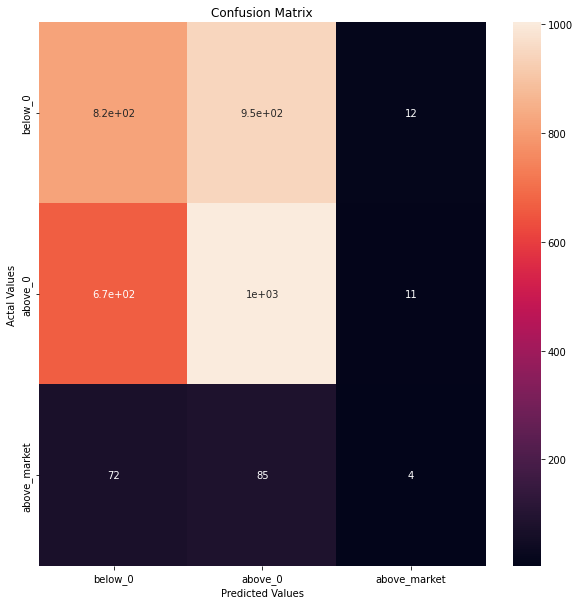

In [ ]:
# Creating  a confusion matrix,which compares the y_test and y_pred
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_target, lgbm_pred)


# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['below_0','above_0','above_market'], 
                     columns = ['below_0','above_0','above_market'])


#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

plt.show()


In [ ]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['below_0','above_0','above_market'], 
                     columns = ['below_0','above_0','above_market'])

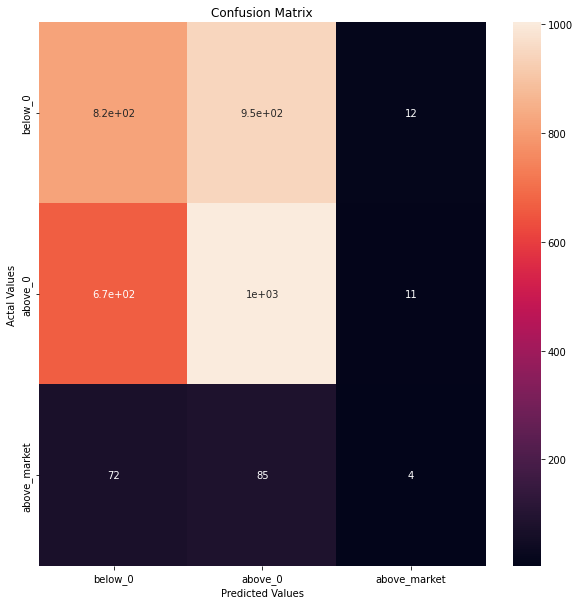

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

plt.show()


In [ ]:
# Saving the file 
import pickle
temp_file_path = '/content/drive/MyDrive/MADS_23_DL_final_project/data/model_files/LGBM_hourly'
with open(temp_file_path + '/Tuned_lgbm_v13_final2.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(untuned_lgbm, f) 

# End of the Notebook